In [1]:
import pandas as pd
from pylab import *
%matplotlib inline
from bs4 import BeautifulSoup
import urllib.request

### Introduction

In this notebook, we scrape Wikipedia information on House races to visualize % of the vote won and seats won over time.

The broad idea is that the number of seats you flip is related to two things: one, how much of the vote you won, and two, *how well you were already doing*. That itself is related to your "natural" appeal (which, we'll see, in the long-run, is more moderate than some notable historical extremes, ignoring voter disenfranchisement and suppression) and how you did in the previous election (which could have been inordinately well).

In other words, you could do terribly in a year and win only 100 seats. But it's possible that in the next election, things snap back to normal, you have around 220 seats, and you gained 120 - but you're roughly 50/50.

### Scrape data

In [2]:
years = list(range(1938, 2019, 2)) # 1938 first year wiki has the % of vote, too
url_base = 'https://en.wikipedia.org/wiki/United_States_House_of_Representatives_elections,_'

In [3]:
def get_summary_table_rows(yr):
    with urllib.request.urlopen('{0:s}{1:d}'.format(url_base, yr)) as r:
        page = r.read()
    soup = BeautifulSoup(page, 'lxml')
    summary_table = soup.find('table', {'class': 'infobox vevent'})
    trs = summary_table.findAll('tr')
    return trs

def get_parties(tr_list):
    my_parties = []
    for tr_elem in tr_list:
        if tr_elem.text[:6] == '\nParty':
            parties = tr_elem.text[6:].strip().replace('\n\n', '\n').replace('  ', ' ').split('\n')
            my_parties += parties
    return my_parties

def get_seats_won(tr_list):
    my_seats_won = []
    for tr_elem in tr_list:
        if tr_elem.text[:10] == '\nSeats\xa0won':
            sw = tr_elem.text[10:].strip().replace('\n\n', '\n').replace('  ', ' ').split('\n')
            my_seats_won += sw
    return my_seats_won

def get_percentage_won(tr_list):
    my_pct = []
    for tr_elem in tr_list:
        if tr_elem.text[:11] == '\nPercentage':
            pcts = tr_elem.text[11:].strip().replace('\n\n', '\n').replace('  ', ' ').split('\n')
            my_pct += pcts
    return my_pct

In [4]:
def get_year_df(yr):
    if yr % 20 == 0:
        print('Starting {0:d}'.format(yr))
    trs = get_summary_table_rows(yr)
    return pd.DataFrame({'Party': get_parties(trs),
                        'Seats': get_seats_won(trs),
                        'Percent': get_percentage_won(trs)}).assign(Year = yr)

election_data = pd.concat([get_year_df(yr) for yr in years])
election_data.head()

Starting 1940
Starting 1960
Starting 1980
Starting 2000


,Party,Percent,Seats,Year
0,Democratic,48.7%,262,1938
1,Republican,47.5%,169,1938
2,Progressive,1.0%,2,1938
3,Farmer–Labor,0.9%,1,1938
4,American Labor,0.7%,1,1938


In [5]:
election_data[election_data.Year == 2018]

,Party,Percent,Seats,Year
0,Democratic,52.8%,231 (potentially 237)[b],2018
1,Republican,45.5%,198 (potentially 204)[b],2018


A little data cleanup:
- Make sure the party names are as expected
- Change percent to a number (removing the percent sign)
- For 2018, remove the parenthetical that there are seats undecided, and add 3 to each party
- Make sure each column is the right type

In [6]:
# Check party names
election_data[['Party']].drop_duplicates()

,Party
0,Democratic
1,Republican
2,Progressive
3,Farmer–Labor
4,American Labor
5,Independent


In [7]:
# Change percent to a number and year to a number
election_data.loc[:, 'Percentage'] = election_data.Percent.str.replace('%', '').astype(float)
election_data.loc[:, 'Year'] = election_data.Year.astype(int)
election_data.head()

,Party,Percent,Seats,Year,Percentage
0,Democratic,48.7%,262,1938,48.7
1,Republican,47.5%,169,1938,47.5
2,Progressive,1.0%,2,1938,1.0
3,Farmer–Labor,0.9%,1,1938,0.9
4,American Labor,0.7%,1,1938,0.7


In [8]:
# Remove parenthetical to seats, add 3 to 2018, change to int
election_data.loc[:, 'Seats won'] = election_data.Seats.str.extract('^([0-9]+).*', expand = False).astype(int)
election_data.loc[election_data.Year == 2018, 'Seats won'] = election_data.loc[election_data.Year == 2018, 'Seats won'] + 3
election_data[election_data.Year == 2018].head()

,Party,Percent,Seats,Year,Percentage,Seats won
0,Democratic,52.8%,231 (potentially 237)[b],2018,52.8,234
1,Republican,45.5%,198 (potentially 204)[b],2018,45.5,201


### Visualization

Let's look at seat share over time.

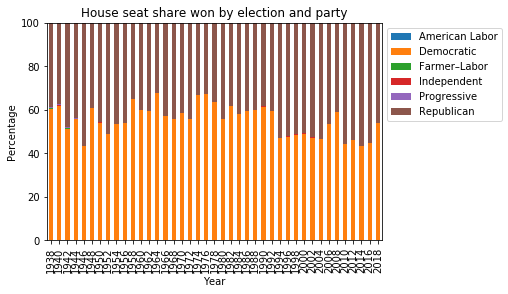

In [9]:
seatshare = election_data[['Party', 'Seats won', 'Year']] \
    .pivot_table(index = "Year", columns = "Party", values = "Seats won") \
    .fillna(0)
yearly_totals = election_data[['Year', 'Seats won']] \
    .groupby('Year').sum() \
    .rename(columns = {'Seats won': 'Total seats'})
# switch to %s
seatshare = seatshare.join(yearly_totals)
for col in seatshare.columns:
    seatshare.loc[:, col] = 100 * seatshare[col] / seatshare['Total seats']
seatshare = seatshare.drop('Total seats', axis = 1)

seatshare.plot(kind = 'bar', stacked = True);
legend(loc = 2, bbox_to_anchor = (1, 1))
title('House seat share won by election and party');
ylabel('Percentage');
xlabel('Year');
ylim(0, 100);
# xticks(range(1940, 2020, 4));

Now, let's drop third parties and, between Democrats and Republicans, let's look at vote share and seat share over time.

In [10]:
dr_data = election_data.query('Party == "Democratic" | Party == "Republican"')
dr_seats = dr_data[["Party", "Seats won", "Year"]].pivot_table(index = "Year", columns = "Party", values = "Seats won")
dr_pct = dr_data[['Party', 'Percentage', 'Year']].pivot_table(index = "Year", columns = "Party", values = "Percentage")

# recalculate based on nums from Ds and Rs
dr_seats.loc[:, 'D Seat Pct'] = dr_seats.Democratic / (dr_seats.Democratic + dr_seats.Republican)
dr_pct.loc[:, 'D Vote Pct'] = dr_pct.Democratic / (dr_pct.Democratic + dr_pct.Republican)

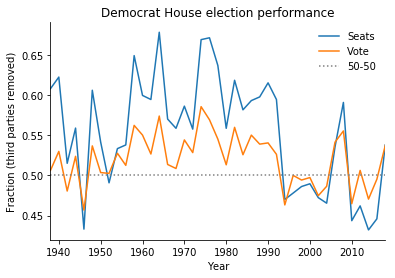

In [11]:
plot(dr_seats['D Seat Pct'], label = 'Seats')
plot(dr_pct['D Vote Pct'], label = 'Vote')
xlim(dr_seats.index.min(), dr_seats.index.max())
plot(xlim(), [.5, .5], ls = ':', color = 'gray', label = '50-50')
xlabel('Year')
ylabel('Fraction (third parties removed)')
title('Democrat House election performance');
gca().spines['right'].set_visible(False)
gca().spines['top'].set_visible(False)
legend(loc = 1, frameon = False);

This type of majority was actually the norm for the Democrats for much of the latter half of the 20th century. It seems like the ["Republican Revolution"](https://en.wikipedia.org/wiki/Republican_Revolution) in the early 1990s may have broken that trend, and now, neither party is capable of gaining large shares of the House. Extremes like 2006-10 were once normal, but now, assuming the last 25 years is any indication, that's no longer true.

Which elections caused the biggest shifts in terms of number of seats?

In [12]:
dr_seats.loc[:, 'Change'] = dr_seats.Democratic - dr_seats.Democratic.shift(1)
dr_seats.loc[:, 'Change_Abs'] = dr_seats.Change.abs()
dr_seats.sort_values('Change_Abs', ascending = False).drop('Change_Abs', axis = 1).head(10)

Party,Democratic,Republican,D Seat Pct,Change
Year,,,,
1948,263,171,0.605991,75.0
2010,193,242,0.443678,-64.0
1946,188,246,0.433180,-54.0
1994,204,230,0.470046,-54.0
1974,291,144,0.668966,49.0
1958,283,153,0.649083,49.0
1966,248,187,0.570115,-47.0
1942,222,209,0.515081,-45.0
2018,234,201,0.537931,40.0


The large shifts tend to happen when the other party is already at a relative extreme. The way we talk about elections, it's like the previous election's result -- regardless of whether it was an extreme -- is the new normal.

To wit, look at the scatterplot of seats in the previous election vs change in the next. It slopes downwards -- indicating the better your position, the worse you could do in terms of net seat change.

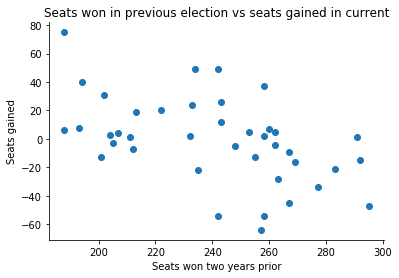

In [13]:
change_df = dr_seats[['Democratic']]
change_df = dr_seats \
    .assign(Previous = lambda x: x.Democratic.shift(1),
            Change = lambda x: x.Democratic - x.Democratic.shift(1)) \
    .dropna()

scatter(change_df.Previous, change_df.Change)
xlabel('Seats won two years prior');
ylabel('Seats gained');
title('Seats won in previous election vs seats gained in current');
gca().spines['right'].set_visible(False)
gca().spines['top'].set_visible(False)

In [14]:
from scipy.stats import linregress
m, b, r, p, e = linregress(change_df.Previous, change_df.Change)
print('Linear regression between starting seat tally and change')
print('Slope = {0:.2f}\nintercept = {1:.2f}\nr2 = {2:.2f}\np = {3:.3f}'.format(m, b, r**2, p))

Linear regression between starting seat tally and change
Slope = -0.48
intercept = 114.80
r2 = 0.24
p = 0.001


According to this simple model, your "starting point" explains 25% of your "election performance" in terms of seats gained/lost. (We could probably do even better adding in whether it was a midterm and the president's party, whether it was a wartime, and change seat totals to seat shares.) It would have predicted the Democrats picking up 21-22 seats. They outperformed that considerably. 